In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from os.path import join
import time
import copy

from utilities.idrid_dataset import idrid_dataset_creator
from utilities import keras_transforms
from utilities import color_transform
from utilities import metrics

from models.tiranus import tiranus11

%load_ext autoreload
%autoreload 2

# Load Data

In [3]:
image_size = 512
mask_size = 512

raw_dir = './inputs/ApparentRetinopathy_Cropped/'
label_dir = './inputs/Masks/HardExudates_Cropped/'
output_dir = './weights'

In [4]:
def train_transforms(image, mask):
    
    # Convert PIL image to 3D numpy
    image = keras_transforms.img_to_array(image, data_format='channels_last')
    mask = keras_transforms.img_to_array(mask, data_format='channels_last')    
    
    result = keras_transforms.random_horizontal_flip([image, mask])
    result = keras_transforms.random_rotation(result, 360, fill_mode='constant')
    result = keras_transforms.random_zoom(result, (1/1.15, 1.15))
    result = keras_transforms.random_shift(result, 0.05, 0.05, fill_mode='constant')
    image, mask = result[0], result[1]    
    #image = color_transform.augment_color(image)
    
    # Convert 3D numpy to PIL image
    image = keras_transforms.array_to_img(image, data_format='channels_last', scale=False)
    mask = keras_transforms.array_to_img(mask, data_format='channels_last', scale=False)
    image = transforms.Resize((image_size, image_size))(image)
    mask = transforms.Resize((mask_size, mask_size))(mask)
        
    # Convert PIL image to Pytorch tensor
    image = transforms.ToTensor()(image)
    mask = transforms.ToTensor()(mask)
    
    image = transforms.Normalize([0.03072981, 0.03072981, 0.01682784], 
                                 [0.17293351, 0.12542403, 0.0771413 ])(image)
    
    return image, mask

def valid_transforms(image, mask):
    # Convert PIL image to 3D numpy
    image = keras_transforms.img_to_array(image, data_format='channels_last')
    mask = keras_transforms.img_to_array(mask, data_format='channels_last')
        
    # Convert 3D numpy to PIL image
    image = keras_transforms.array_to_img(image, data_format='channels_last', scale=False)
    mask = keras_transforms.array_to_img(mask, data_format='channels_last', scale=False)
    image = transforms.Resize((image_size, image_size))(image)
    mask = transforms.Resize((mask_size, mask_size))(mask)
    
    # Convert PIL image to Pytorch tensor
    image = transforms.ToTensor()(image)
    mask = transforms.ToTensor()(mask)
    
    image = transforms.Normalize([0.03072981, 0.03072981, 0.01682784], 
                                 [0.17293351, 0.12542403, 0.0771413 ])(image)

    return image, mask

data_transforms = {
    'train': train_transforms,
    'val': valid_transforms
}

ix_train, ix_valid = train_test_split(range(1,55), test_size=0.2, random_state=42)
ix = {'train': ix_train, 'val': ix_valid}
image_datasets = {x: idrid_dataset_creator(raw_dir, label_dir, '_EX.tif', ix[x],
                                           transform=data_transforms[x], cache=False)()
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=10,
                                              shuffle=True, 
                                              num_workers=8,
                                              pin_memory=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

print('Cuda is available: {}'.format(torch.cuda.is_available()))

43 0
43 0
11 0
11 0
Cuda is available: True


# Visualize a few images

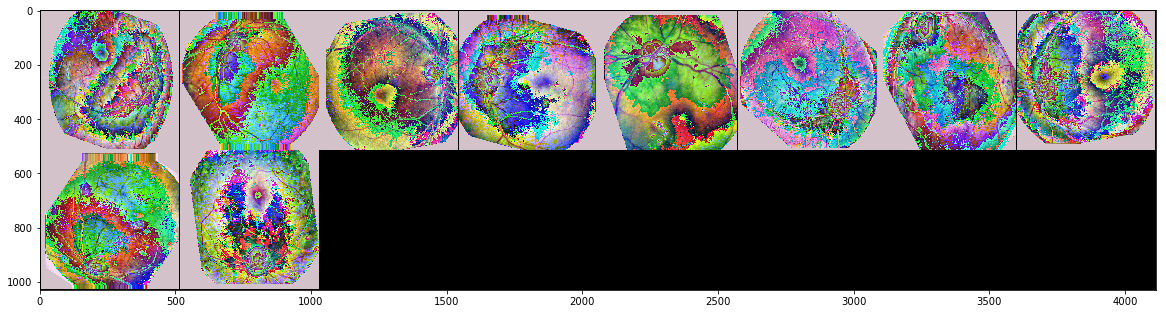

In [5]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.4238, 0.2771, 0.2058])
    #std = np.array([0.2563, 0.2112, 0.1632])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20, 20))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
samples = next(iter(dataloaders['train']))
#print(samples['raw'].shape)
#print('-->', samples['label'].shape)

# Make a grid from batch
imgs = torchvision.utils.make_grid(samples['raw'])
imshow(imgs)

# Training the model

In [5]:
def train_model(model, criterion, optimizer, scheduler = None,
                save_path = None, num_epochs = 25, threshold=0.5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 999999999
    best_dice = 0.0
    best_sn = 0.0
    best_ppv = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_dice = 0.0
            running_sn = 0.0
            running_ppv = 0.0
            
            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data['raw'], data['label']

                # wrap them in Variable
                inputs = Variable(inputs.cuda(async=True))
                labels = Variable(labels.cuda(async=True))

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                logits = model(inputs)

                loss = criterion(logits, labels)
                metric_dice = metrics.dice_value(logits, labels)
                metric_sn  = metrics.SN(logits, labels, threshold) 
                metric_ppv = metrics.PPV(logits, labels, threshold)
                
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_dice += metric_dice.data[0] * inputs.size(0)
                running_sn += metric_sn.data[0] * inputs.size(0)
                running_ppv += metric_ppv.data[0] * inputs.size(0)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_dice = running_dice / dataset_sizes[phase]
            epoch_sn = running_sn / dataset_sizes[phase]
            epoch_ppv = running_ppv / dataset_sizes[phase]
                        
            print('{} Loss: {:.4f}, DICE: {:.4f}, SN: {:.4f}, PPV: {:.4f}'.format(
                phase, epoch_loss, epoch_dice, epoch_sn, epoch_ppv))
            if phase == 'val' and scheduler is not None:
                scheduler.step(epoch_dice)
            
            # deep copy the model
            if (phase == 'val') and (epoch_dice > best_dice): #or (epoch_ppv > best_ppv)):
                best_loss = epoch_loss
                best_dice = epoch_dice
                best_sn = epoch_sn
                best_ppv = epoch_ppv
                best_model_wts = copy.deepcopy(model.state_dict())
                if save_path is not None:
                    path = save_path.format(best_loss, best_dice, best_sn, best_ppv)
                    torch.save(best_model_wts, path)
                    print('Weights of model saved at {}'.format(path))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}, Best val DICE: {:4f}, Best val SN: {:4f}, Best val PPV: {:4f}'.format(
        best_loss, best_dice, best_sn, best_ppv))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Config Model

In [6]:
model = tiranus11(pretrained='retina+carvana', freeze_encoder=True)
model = model.cuda()

criterion = metrics.criterion_fn

# Observe that all parameters are being optimized
#optimizer = optim.SGD(filter(lambda p:  p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)
optimizer = optim.Adam(filter(lambda p:  p.requires_grad, model.parameters()), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)

# Train and evaluate

In [7]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, 
                    'weights/tiranus(rc-dec)-{:.4f}-{:.4f}-{:.4f}-{:.4f}.pt', num_epochs=50)

Epoch 0/49
----------
train Loss: 2.2743, DICE: 0.0012, SN: 0.1575, PPV: 0.7686
val Loss: 1.1378, DICE: 0.0029, SN: 0.0004, PPV: 1.0000
Weights of model saved at weights/tiranus(rc-dec)-1.1378-0.0029-0.0004-1.0000.pt

Epoch 1/49
----------
train Loss: 1.1169, DICE: 0.0073, SN: 0.0006, PPV: 1.0000
val Loss: 1.1080, DICE: 0.0294, SN: 0.0004, PPV: 1.0000
Weights of model saved at weights/tiranus(rc-dec)-1.1080-0.0294-0.0004-1.0000.pt

Epoch 2/49
----------
train Loss: 1.1046, DICE: 0.0074, SN: 0.0006, PPV: 1.0000
val Loss: 1.0089, DICE: 0.0064, SN: 0.0004, PPV: 1.0000

Epoch 3/49
----------
train Loss: 0.9877, DICE: 0.0422, SN: 0.0015, PPV: 0.7223
val Loss: 0.9153, DICE: 0.0056, SN: 0.0179, PPV: 0.5300

Epoch 4/49
----------
train Loss: 0.8585, DICE: 0.2376, SN: 0.1470, PPV: 0.4886
val Loss: 0.7709, DICE: 0.2888, SN: 0.5931, PPV: 0.3704
Weights of model saved at weights/tiranus(rc-dec)-0.7709-0.2888-0.5931-0.3704.pt

Epoch 5/49
----------
train Loss: 0.7435, DICE: 0.1569, SN: 0.5889, PPV:

In [10]:
weight_path = join(output_dir, '01/tiranus(rc-dec)-0.4526-0.7409-0.6559-0.7299.pt')
optimizer = optim.Adam(filter(lambda p:  p.requires_grad, model.parameters()), lr=0.0001)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)
model.load_state_dict(torch.load(weight_path))
model = train_model(model, criterion, optimizer, exp_lr_scheduler, 
                    'weights/tiranus(rc-dec)-{:.4f}-{:.4f}-{:.4f}-{:.4f}.pt', num_epochs=50)

Epoch 0/49
----------
train Loss: 0.3595, DICE: 0.7317, SN: 0.7470, PPV: 0.7505
val Loss: 0.4443, DICE: 0.4591, SN: 0.7436, PPV: 0.6383
Weights of model saved at weights/tiranus(rc-dec)-0.4443-0.4591-0.7436-0.6383.pt

Epoch 1/49
----------
train Loss: 0.3574, DICE: 0.6041, SN: 0.7539, PPV: 0.7049
val Loss: 0.4530, DICE: 0.5013, SN: 0.6852, PPV: 0.6998
Weights of model saved at weights/tiranus(rc-dec)-0.4530-0.5013-0.6852-0.6998.pt

Epoch 2/49
----------
train Loss: 0.3528, DICE: 0.6713, SN: 0.7526, PPV: 0.7564
val Loss: 0.4485, DICE: 0.5162, SN: 0.7165, PPV: 0.6587
Weights of model saved at weights/tiranus(rc-dec)-0.4485-0.5162-0.7165-0.6587.pt

Epoch 3/49
----------
train Loss: 0.3517, DICE: 0.6615, SN: 0.7701, PPV: 0.7334
val Loss: 0.4476, DICE: 0.6291, SN: 0.7004, PPV: 0.6644
Weights of model saved at weights/tiranus(rc-dec)-0.4476-0.6291-0.7004-0.6644.pt

Epoch 4/49
----------
train Loss: 0.3507, DICE: 0.6220, SN: 0.7499, PPV: 0.7391
val Loss: 0.4492, DICE: 0.7372, SN: 0.6905, PPV:

In [16]:
weight_path = join(output_dir, '02/tiranus(rc-dec)-0.4479-0.7500-0.6982-0.6678.pt')
model.unfreeze_encoder()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)
model.load_state_dict(torch.load(weight_path))

In [18]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, 
                    'weights/tiranus(rc)-{:.4f}-{:.4f}-{:.4f}-{:.4f}.pt', num_epochs=50)

Epoch 0/49
----------
train Loss: 0.3738, DICE: 0.6580, SN: 0.7695, PPV: 0.6883
val Loss: 0.4928, DICE: 0.6992, SN: 0.6077, PPV: 0.7414
Weights of model saved at weights/tiranus(rc)-0.4928-0.6992-0.6077-0.7414.pt

Epoch 1/49
----------
train Loss: 0.3792, DICE: 0.6166, SN: 0.6662, PPV: 0.7890
val Loss: 0.4501, DICE: 0.3701, SN: 0.7330, PPV: 0.5324

Epoch 2/49
----------
train Loss: 0.3955, DICE: 0.4995, SN: 0.7818, PPV: 0.5842
val Loss: 0.4474, DICE: 0.3406, SN: 0.6903, PPV: 0.6750

Epoch 3/49
----------
train Loss: 0.3774, DICE: 0.6815, SN: 0.7096, PPV: 0.7458
val Loss: 0.4370, DICE: 0.5073, SN: 0.7066, PPV: 0.6822

Epoch 4/49
----------
train Loss: 0.3599, DICE: 0.7071, SN: 0.7529, PPV: 0.7157
val Loss: 0.4610, DICE: 0.5359, SN: 0.7124, PPV: 0.6529

Epoch 5/49
----------
train Loss: 0.3610, DICE: 0.6972, SN: 0.7508, PPV: 0.7639
val Loss: 0.4468, DICE: 0.7186, SN: 0.6985, PPV: 0.6708
Weights of model saved at weights/tiranus(rc)-0.4468-0.7186-0.6985-0.6708.pt

Epoch 6/49
----------
tr

In [8]:
weight_path = join(output_dir, '03/tiranus(rc)-0.4617-0.7525-0.6835-0.7011.pt')
optimizer = optim.Adam(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
model.load_state_dict(torch.load(weight_path))

In [9]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, 
                    'weights/tiranus(rc)-{:.4f}-{:.4f}-{:.4f}-{:.4f}.pt', num_epochs=50)

Epoch 0/49
----------
train Loss: 0.3892, DICE: 0.6171, SN: 0.7450, PPV: 0.7075
val Loss: 0.4782, DICE: 0.5047, SN: 0.6371, PPV: 0.7329
Weights of model saved at weights/tiranus(rc)-0.4782-0.5047-0.6371-0.7329.pt

Epoch 1/49
----------
train Loss: 0.3739, DICE: 0.6084, SN: 0.7615, PPV: 0.7403
val Loss: 0.4493, DICE: 0.6824, SN: 0.7670, PPV: 0.5875
Weights of model saved at weights/tiranus(rc)-0.4493-0.6824-0.7670-0.5875.pt

Epoch 2/49
----------
train Loss: 0.3606, DICE: 0.6793, SN: 0.7744, PPV: 0.7111
val Loss: 0.4647, DICE: 0.7463, SN: 0.6580, PPV: 0.7178
Weights of model saved at weights/tiranus(rc)-0.4647-0.7463-0.6580-0.7178.pt

Epoch 3/49
----------
train Loss: 0.3660, DICE: 0.6202, SN: 0.7253, PPV: 0.7963
val Loss: 0.4474, DICE: 0.7427, SN: 0.7155, PPV: 0.6533

Epoch 4/49
----------
train Loss: 0.3543, DICE: 0.6465, SN: 0.7791, PPV: 0.7202
val Loss: 0.4449, DICE: 0.7378, SN: 0.7133, PPV: 0.6800

Epoch 5/49
----------
train Loss: 0.3549, DICE: 0.6809, SN: 0.7633, PPV: 0.7608
val 

In [ ]:
model1 = tiranus11(pretrained='vgg', freeze_encoder=True)
model1 = model1.cuda()
criterion = metrics.criterion_fn
optimizer = optim.Adam(filter(lambda p:  p.requires_grad, model1.parameters()), lr=0.001)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)
model1 = train_model(model1, criterion, optimizer, exp_lr_scheduler, 
                    'weights/tiranus(vgg-dec)-{:.4f}-{:.4f}-{:.4f}-{:.4f}.pt', num_epochs=50)

Epoch 0/49
----------
train Loss: 1.4580, DICE: 0.0113, SN: 0.2326, PPV: 0.7317
val Loss: 1.3237, DICE: 0.0006, SN: 0.0004, PPV: 1.0000
Weights of model saved at weights/tiranus(vgg-dec)-1.3237-0.0006-0.0004-1.0000.pt

Epoch 1/49
----------
train Loss: 1.2102, DICE: 0.0027, SN: 0.0006, PPV: 1.0000
val Loss: 1.1270, DICE: 0.0146, SN: 0.0004, PPV: 1.0000
Weights of model saved at weights/tiranus(vgg-dec)-1.1270-0.0146-0.0004-1.0000.pt

Epoch 2/49
----------
train Loss: 1.1164, DICE: 0.0128, SN: 0.0006, PPV: 1.0000
val Loss: 1.0647, DICE: 0.0303, SN: 0.0004, PPV: 1.0000
Weights of model saved at weights/tiranus(vgg-dec)-1.0647-0.0303-0.0004-1.0000.pt

Epoch 3/49
----------
train Loss: 1.0403, DICE: 0.0214, SN: 0.0004, PPV: 1.0000
val Loss: 0.9884, DICE: 0.0731, SN: 0.0004, PPV: 1.0000
Weights of model saved at weights/tiranus(vgg-dec)-0.9884-0.0731-0.0004-1.0000.pt

Epoch 4/49
----------
train Loss: 0.9435, DICE: 0.0813, SN: 0.0005, PPV: 1.0000
val Loss: 0.8759, DICE: 0.2081, SN: 0.0004, 

# Visualize masks

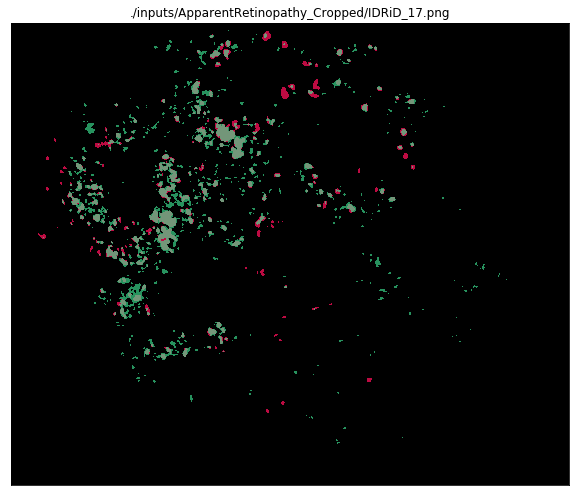

In [25]:
from utilities.visualization import show_mask 
%matplotlib inline

#model = tiranus11(pretrained=None, freeze_encoder=False)
#model = model.cuda()
weight_path = join(output_dir, '03/tiranus(rc)-0.4617-0.7525-0.6835-0.7011.pt')
model.load_state_dict(torch.load(weight_path))
model.train(False)

img_path = join(raw_dir, 'IDRiD_17.png')
mask_path = join(label_dir, 'IDRiD_17_EX.tif')
show_mask(model, img_path, mask_path, threshold=None, show_img=False)